<a href="https://colab.research.google.com/github/Mayank2434/Assignments/blob/main/3_Code_Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [ ]:
#a) Load the oxford_iiit_pet dataset
dataset,info = tfds.load('oxford_iiit_pet:3.2.0', split='train', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQQXSFT/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQQXSFT/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], [128, 128])     #Resize the data['image'] to 128x128
  input_mask =tf.image.resize(data['segmentation_mask'], [128, 128])     #Resize the data['segmentation_mask'] to 128x128

  input_image = tf.image.convert_image_dtype(input_image, tf.float32)/255 # [0,1]
  input_mask -= 1 # {1,2,3} to {0,1,2}

  return input_image, input_mask

In [ ]:
train_data = dataset.map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_data, _ = tfds.load('oxford_iiit_pet:3.2.0', split='test', with_info=True)
test_data = test_data.map(read_and_preprocess)

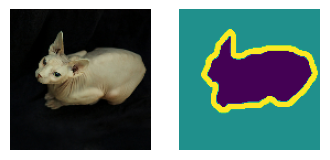

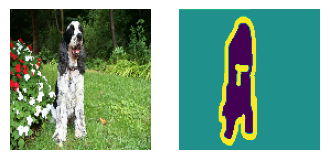

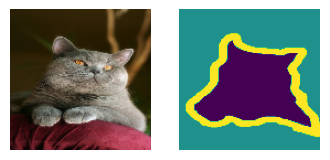

In [ ]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version
for input_image, input_mask in train_data.take(3):
    plt.figure(figsize=(4, 2))

    # image
    plt.subplot(1,2,1)
    plt.imshow(input_image)
    plt.axis('off')

    # Segmented version
    plt.subplot(1,2,2)
    plt.imshow(input_mask.numpy().squeeze(), cmap='viridis', vmin=0, vmax=2)
    plt.axis('off')

    plt.show()

**Part 2- Annotation**

In [ ]:
pip install mrcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54907 sha256=c8c8659063bb022b1844394dc7098b8771a48bbb58ef693e3a9dc3c860a86c09
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [ ]:
# Get data from here https://github.com/experiencor/raccoon_dataset
import os
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import cv2
dataset_dir = "/content/raccoon_dataset"
os.makedirs(dataset_dir, exist_ok=True)

url = "https://github.com/experiencor/raccoon_dataset/archive/master.zip"
zip_file_path = os.path.join(dataset_dir, "raccoon_dataset.zip")
extracted_folder_name = "raccoon_dataset-master"
urllib.request.urlretrieve(url, zip_file_path)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

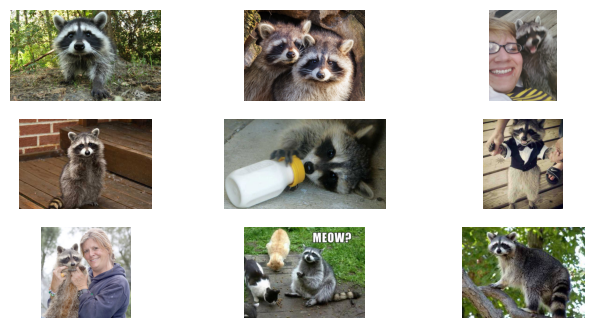

In [ ]:

# Now, let's display some sample images
images_dir = os.path.join(dataset_dir, extracted_folder_name, "images")
sample_images = os.listdir(images_dir)[:9]

plt.figure(figsize=(8, 4))
for i, image_name in enumerate(sample_images, 1):
    image_path = os.path.join(images_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.axis('off')  # Turn off axes

plt.show()






In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

class RaccoonDataset(Dataset):
    # class that defines and loads the raccoon dataset
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("raccoon_dataset", 1, "raccoon")
        # define data locations
        images_dir = os.path.join(dataset_dir, extracted_folder_name, "images")
        annotations_dir = os.path.join(dataset_dir, 'annotations')
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[8:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = os.path.join(images_dir, filename)
            ann_path = os.path.join(annotations_dir, 'raccoon-' + image_id + '.xml')
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        # path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   # Added by me
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('raccoon'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))



Train: 149
Test: 51


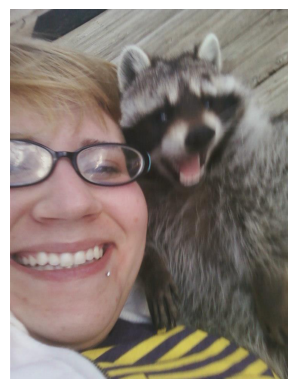

In [ ]:
image_id = 2

# Load the image
image = train_set.load_image(image_id)
plt.imshow(image)
plt.axis('off')
plt.show()

# Load the corresponding mask
mask, class_ids = train_set.load_mask(image_id)



**Part 3- YOLO 8**




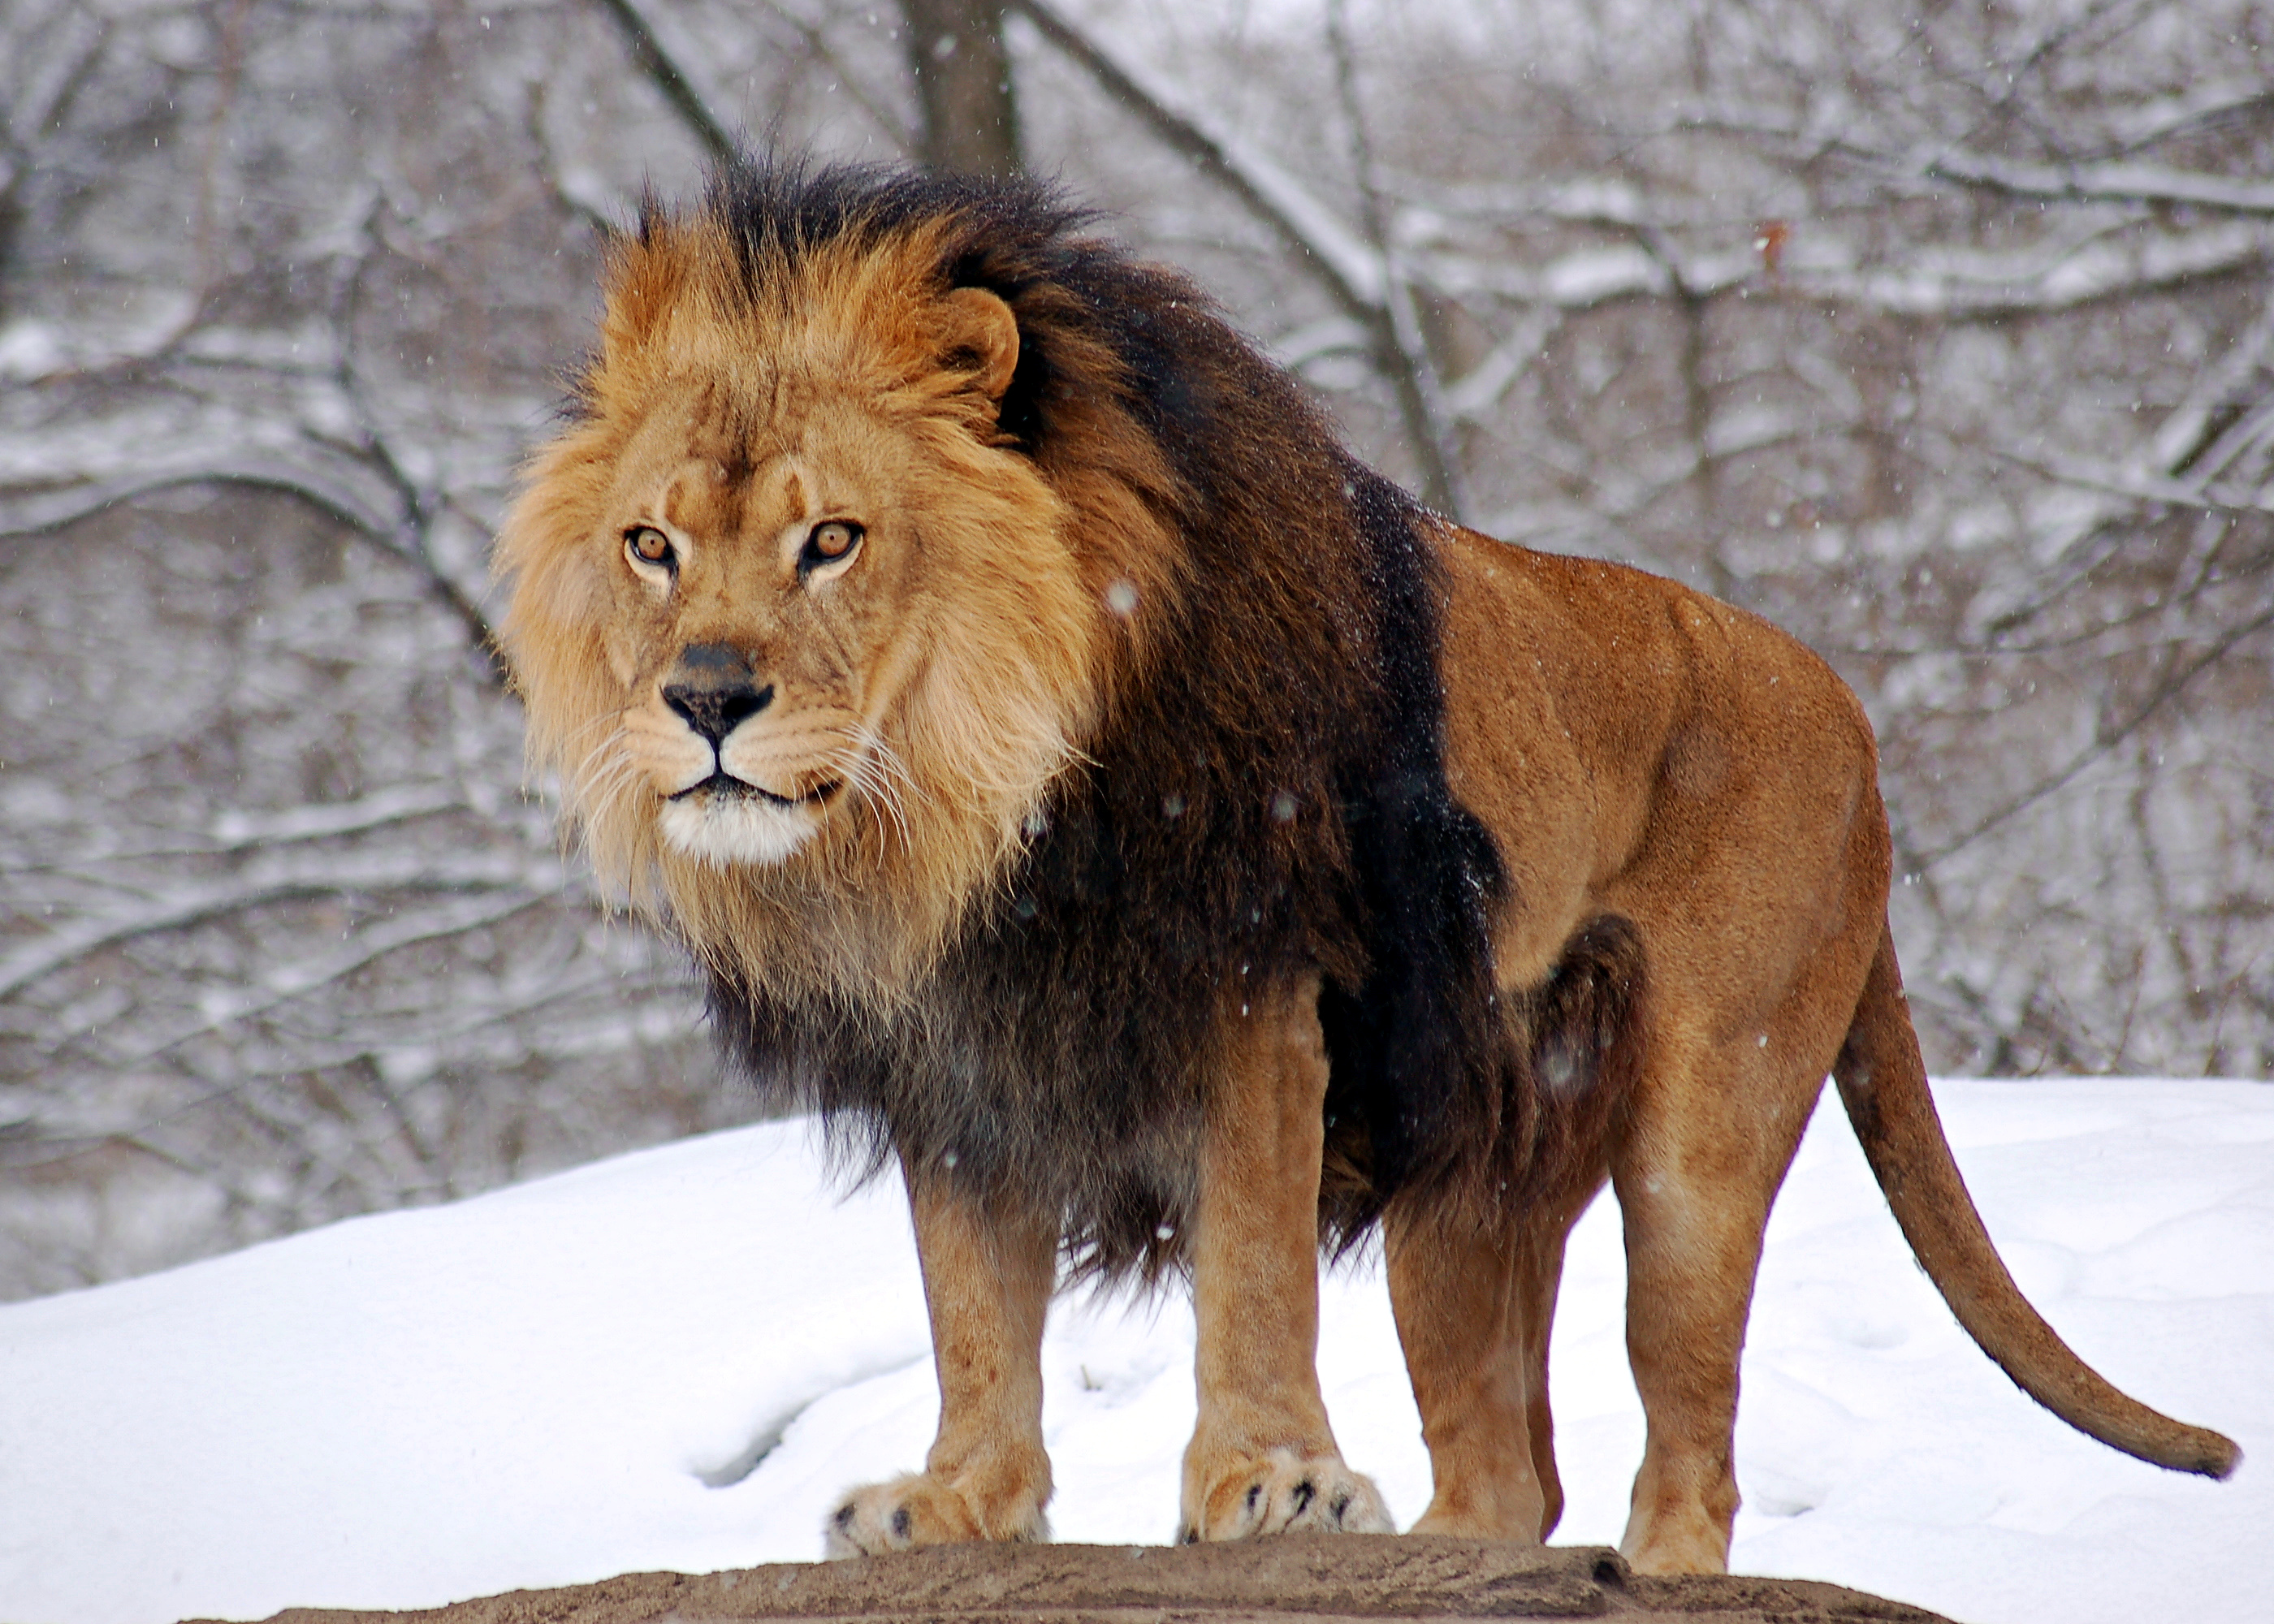

This image shows a lion in the wild.

In [ ]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module
from IPython.display import display, Image, Markdown
image_path = "/content/lion.jpeg"
display(Image(filename=image_path))
annotation = "This image shows a lion in the wild."
Markdown(annotation)


In [ ]:

#b- Now, we want to install Yolo8.
# Download required tools
# Clone yolo 8 and check all dependencies
!git clone https://github.com/ultralytics/ultralytics.git






fatal: destination path 'ultralytics' already exists and is not an empty directory.


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data='coco128.yaml', epochs=100, imgsz=640)

In [ ]:
#d- Test model
#Import ultralytics
# Test this above trained model on an image. For example: https://ultralytics.com/images/bus.jpg
from PIL import Image
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Run inference on 'bus.jpg'
results = model('bus.jpg')  # results list

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results.jpg')  # save image

In [ ]:
# e- See the result.
# Show the result and all the assigned objects here

In [ ]:
# What is your understanding from this image? What is the meaning of these numbers all over the image?